In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.5.1-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]='/content/spark-3.5.1-bin-hadoop3'

In [ ]:
!pip install -q findspark
import findspark

In [ ]:
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.5.1-bin-hadoop3'

In [ ]:
from pyspark.sql.functions import col

In [ ]:
import pyspark
sc = pyspark.SparkContext(appName="learningpyspark33")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Analysis of Offences Causing Death').getOrCreate()

df = spark.read.csv('/content/drive/MyDrive/hiscrimdata.csv', header=True, inferSchema=True)

In [ ]:
df_death = df.filter(
    (col("Type") == "Vehicle Collision or Pedestrian Struck (with Fatality)") |
    (col("Type") == 'Homicide')
)
# Add ID in datafame
df_death.show()

+--------------------+----+-----+---+----+------+--------------------+--------------------+-----------+------------+
|                TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|       HUNDRED_BLOCK|       NEIGHBOURHOOD|          X|           Y|
+--------------------+----+-----+---+----+------+--------------------+--------------------+-----------+------------+
|Vehicle Collision...|2005|   11| 30|   2|    41|10XX BLOCK EXPO BLVD|Central Business ...|   491543.0|   5458003.0|
|Vehicle Collision...|2005|   11| 11|   1|    10|  10XX W HASTINGS ST|Central Business ...|   491461.0|   5459401.0|
|Vehicle Collision...|2009|    2|  9|  15|    31| 11XX BLOCK DAVIE ST|            West End|   490431.0|   5458660.0|
|Vehicle Collision...|2006|   10| 22|  22|    26|11XX BLOCK E 60TH...|              Sunset|   493983.0|   5451421.0|
|Vehicle Collision...|2018|   12| 27|   5|     1|11XX BLOCK KINGSW...|Kensington-Cedar ...|   494071.0|   5455562.0|
|Vehicle Collision...|2015|    8| 19|  22|    27|11XX BLOCK SE M

In [ ]:
from pyspark.sql.functions import col, sum

#Find Missing values
missing_data_counts = df_death.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data_counts.show()

+----+----+-----+---+----+------+-------------+-------------+---+---+
|TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|HUNDRED_BLOCK|NEIGHBOURHOOD|  X|  Y|
+----+----+-----+---+----+------+-------------+-------------+---+---+
|   0|   0|    0|  0|   0|     0|            0|            3|  0|  0|
+----+----+-----+---+----+------+-------------+-------------+---+---+



In [ ]:
#Process data
df_death = df_death.dropna() #Drop the null rows
df_death = df_death.dropDuplicates() # Remove duplicate rows
df_death.show()

+--------------------+----+-----+---+----+------+--------------------+--------------------+--------+---------+
|                TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|       HUNDRED_BLOCK|       NEIGHBOURHOOD|       X|        Y|
+--------------------+----+-----+---+----+------+--------------------+--------------------+--------+---------+
|Vehicle Collision...|2019|   11| 24|  13|    54| 5XX BLOCK NELSON ST|Central Business ...|491184.0|5458374.0|
|Vehicle Collision...|2016|    2|  8|  11|    51|E 49TH AVE / FRAS...|              Sunset|493395.0|5452521.0|
|Vehicle Collision...|2014|   12| 25|  22|    38|KINGSWAY AVE / EA...| Renfrew-Collingwood|496446.0|5453866.0|
|            Homicide|2019|    6| 26|   0|     0|OFFSET TO PROTECT...|              Sunset|     0.0|      0.0|
|            Homicide|2018|    1| 18|   0|     0|OFFSET TO PROTECT...| Renfrew-Collingwood|     0.0|      0.0|
|            Homicide|2011|   11|  6|   0|     0|OFFSET TO PROTECT...|      Mount Pleasant|     0.0|      0.0|
|

In [ ]:
df_death_summary = df_death.describe()
df_death_summary.show()

+-------+--------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+---------------+------------------+------------------+
|summary|                TYPE|              YEAR|            MONTH|               DAY|             HOUR|            MINUTE|       HUNDRED_BLOCK|  NEIGHBOURHOOD|                 X|                 Y|
+-------+--------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+---------------+------------------+------------------+
|  count|                 583|               583|              583|               583|              583|               583|                 583|            583|               583|               583|
|   mean|                NULL|2010.6449399656947|6.262435677530017|15.550600343053173|6.497427101200686|15.478559176672384|                NULL|           NULL|256887.79759862777|2844935.3361921096|
| std

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat_ws, col, to_date, date_format, sum, avg
from pyspark.sql.functions import dayofmonth, ceil


df_death = df_death.withColumn("Date", concat_ws("-", col("YEAR"), col("MONTH"), col("DAY")))
df_death = df_death.withColumn("Date", col("Date").cast("date"))

df_death = df_death.withColumn("day", dayofmonth("Date"))
df_death = df_death.withColumn("week_of_month", ceil(df_death.day / 7))

df_death.createOrReplaceTempView("CrimeData")

What are the most common types of offenses causing death (e.g., homicide, fatal vehicle collisions)? give percentage

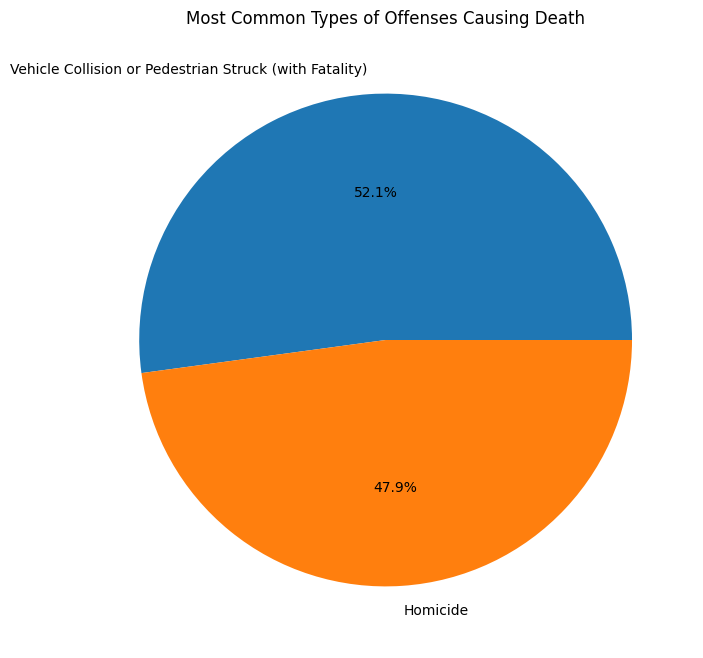

In [ ]:

q1 = spark.sql("""
SELECT TYPE, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE
ORDER BY Count DESC
""")

result1 = q1.toPandas()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(result1['Count'], labels=result1['TYPE'], autopct='%1.1f%%')
plt.title('Most Common Types of Offenses Causing Death')
plt.show()

What are the peak times for offenses causing death during a 24-hour period?

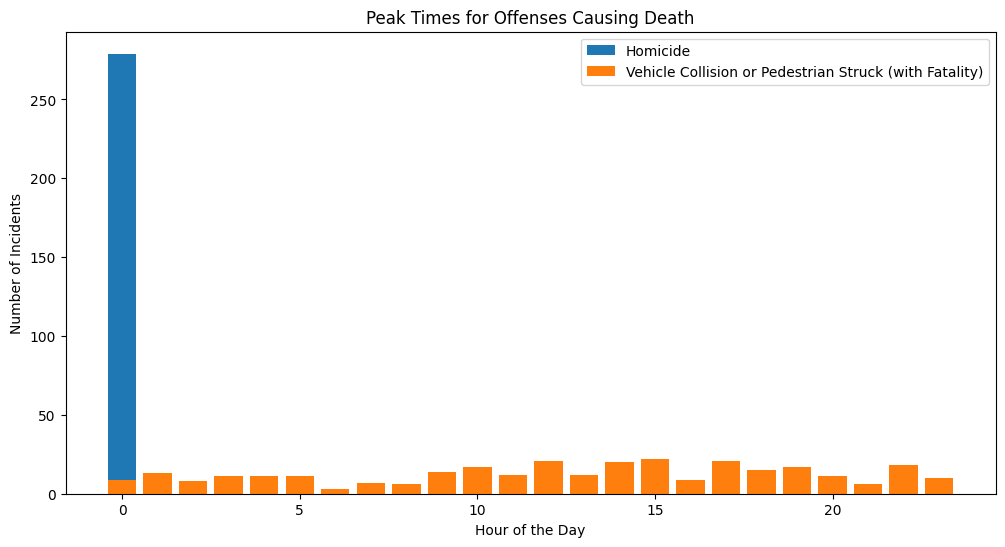

In [ ]:
query = spark.sql("""
SELECT TYPE, HOUR, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, HOUR
ORDER BY Count DESC
""")

query_df = query.toPandas()

# Plot bar chart
plt.figure(figsize=(12, 6))
for crime_type in query_df['TYPE'].unique():
    subset = query_df[query_df['TYPE'] == crime_type]
    plt.bar(subset['HOUR'], subset['Count'], label=crime_type)

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.title('Peak Times for Offenses Causing Death')
plt.legend()

How do rates of offenses causing death fluctuate throughout the week?

In [ ]:
q2 = spark.sql("""
SELECT TYPE, week_of_month AS Week, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, week_of_month
ORDER BY Count DESC
""")

q2_df = q2.toPandas()

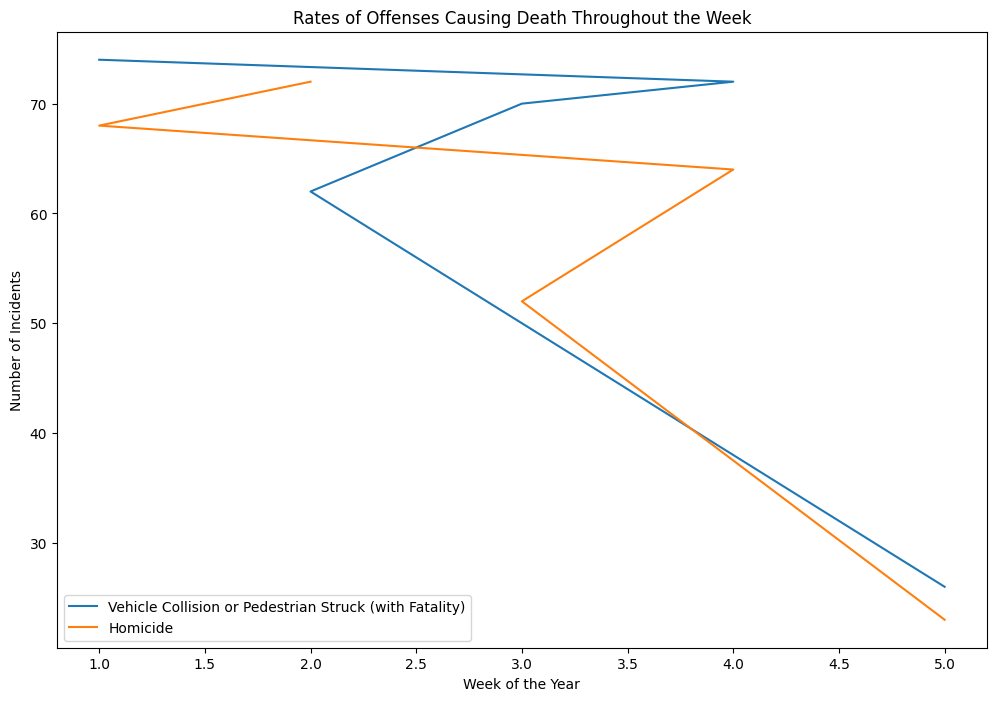

In [ ]:
# Create a line plot
plt.figure(figsize=(12, 8))
for crime_type in q2_df['TYPE'].unique():
    subset = q2_df[q2_df['TYPE'] == crime_type]
    plt.plot(subset['Week'], subset['Count'], label=crime_type)

plt.xlabel('Week of the Year')
plt.ylabel('Number of Incidents')
plt.title('Rates of Offenses Causing Death Throughout the Week')
plt.legend()

Are there identifiable trends in offenses causing death over multiple years?

<ipython-input-21-083ba14b87ba>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=result3, x='YEAR', y='Count', hue='TYPE', ci=None)


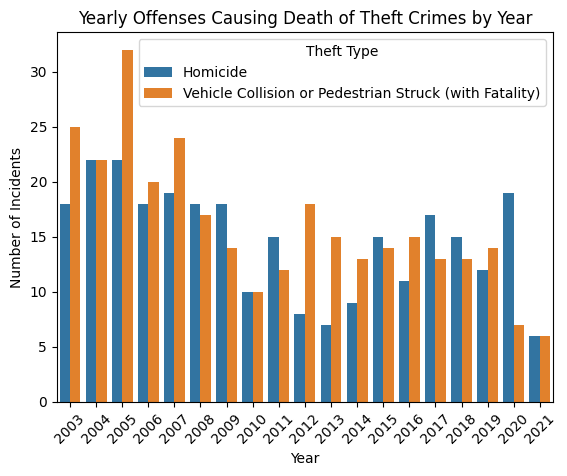

In [ ]:
import seaborn as sns

query3 = spark.sql( """
SELECT TYPE, YEAR, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, YEAR
ORDER BY YEAR, TYPE
""")

result3 = query3.toPandas()

# Create a stacked bar plot
sns.barplot(data=result3, x='YEAR', y='Count', hue='TYPE', ci=None)
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Yearly Offenses Causing Death of Theft Crimes by Year')
plt.xticks(rotation=45)
plt.legend(title='Theft Type')
plt.show()

How do rates of offenses causing death vary by the day of the month?

<ipython-input-22-230bbcbcde24>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=result4, x='day', y='Count', hue='TYPE', ci=None)


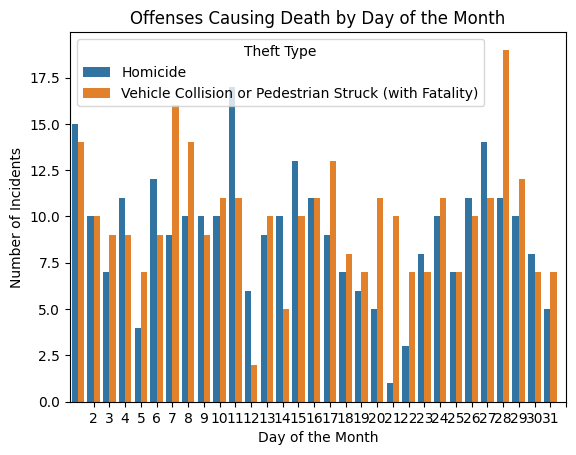

In [ ]:
query4 = spark.sql(
"""
SELECT TYPE, day, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, day
ORDER BY Count DESC
""")

result4 = query4.toPandas()

# Create a stacked bar plot
sns.barplot(data=result4, x='day', y='Count', hue='TYPE', ci=None)
plt.xlabel('Day of the Month')
plt.ylabel('Number of Incidents')
plt.title('Offenses Causing Death by Day of the Month')
plt.xticks(range(1, 32))
plt.legend(title='Theft Type')
plt.show()

Are there specific months with higher incidences of offenses causing death?

<ipython-input-23-9762679bc601>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=result5, x='MONTH', y='Count', hue='TYPE', ci=None)


Text(0.5, 1.0, 'Offenses Causing Death by Month')

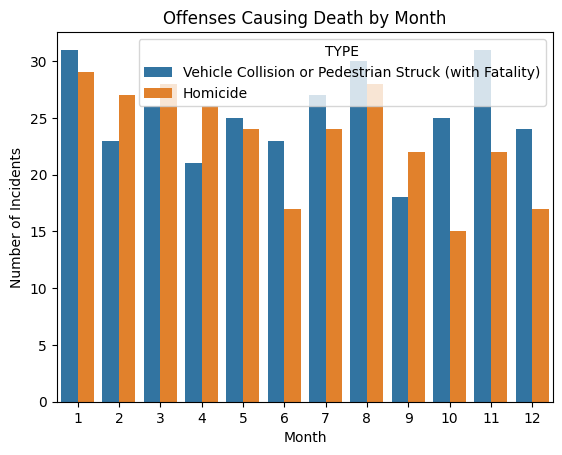

In [ ]:
query5 = spark.sql("""
SELECT TYPE, MONTH, COUNT(*) AS Count
FROM CrimeData
GROUP BY TYPE, MONTH
ORDER BY Count DESC
""")

result5 = query5.toPandas()

# Create a stacked bar plot
sns.barplot(data=result5, x='MONTH', y='Count', hue='TYPE', ci=None)
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.title('Offenses Causing Death by Month')

Which blocks have the highest concentration of offenses causing death, and how do these hotspots evolve?

In [ ]:
# Find top 10 nighbourhoods each type
query6 = spark.sql(
    """
    SELECT TYPE, HUNDRED_BLOCK, COUNT(*) AS Count
    FROM CrimeData
    GROUP BY TYPE, HUNDRED_BLOCK
    ORDER BY Count DESC
    """
)

result6_df = query6.toPandas()

# Filter the data to include only the high-risk blocks
high_risk_block_ids = result6_df['HUNDRED_BLOCK'].tolist()
high_risk_blocks = result6_df[result6_df['HUNDRED_BLOCK'].isin(high_risk_block_ids)]
display(high_risk_blocks)

# Create a Spark DataFrame for the high-risk blocks
high_risk_spark_df = spark.createDataFrame(high_risk_blocks)

# Create a temporary view for the high-risk blocks
high_risk_spark_df.createOrReplaceTempView("high_risk_blocks")

# Query to get the trend of theft from vehicles in high-risk blocks last 5 months
result_highrisk = spark.sql("""
SELECT TYPE, HUNDRED_BLOCK, YEAR, MONTH, COUNT(*) AS Count
FROM CrimeData
WHERE YEAR = 2021 AND HUNDRED_BLOCK IN (SELECT HUNDRED_BLOCK FROM high_risk_blocks)
GROUP BY HUNDRED_BLOCK, YEAR, MONTH, TYPE
ORDER BY HUNDRED_BLOCK, MONTH
""")

result_highrisk.show()

,TYPE,HUNDRED_BLOCK,Count
0,Homicide,OFFSET TO PROTECT PRIVACY,279
1,Vehicle Collision or Pedestrian Struck (with F...,MAIN ST / E HASTINGS ST,5
2,Vehicle Collision or Pedestrian Struck (with F...,E HASTINGS ST / JACKSON AVE,2
3,Vehicle Collision or Pedestrian Struck (with F...,CAMBIE ST / DUNSMUIR ST,2
4,Vehicle Collision or Pedestrian Struck (with F...,MAIN ST / KEEFER ST,2
...,...,...,...
289,Vehicle Collision or Pedestrian Struck (with F...,42XX W 4TH AVE,1
290,Vehicle Collision or Pedestrian Struck (with F...,E KING EDWARD AVE / INVERNESS ST,1
291,Vehicle Collision or Pedestrian Struck (with F...,POWELL ST / GORE AVE,1
292,Vehicle Collision or Pedestrian Struck (with F...,E 55TH AVE / KERR ST,1


+--------------------+--------------------+----+-----+-----+
|                TYPE|       HUNDRED_BLOCK|YEAR|MONTH|Count|
+--------------------+--------------------+----+-----+-----+
|Vehicle Collision...|36XX BLOCK FOSTER...|2021|    3|    1|
|Vehicle Collision...|E CORDOVA ST / PR...|2021|    4|    1|
|Vehicle Collision...|MCKINNON ST / E 5...|2021|    2|    1|
|            Homicide|OFFSET TO PROTECT...|2021|    1|    2|
|            Homicide|OFFSET TO PROTECT...|2021|    3|    1|
|            Homicide|OFFSET TO PROTECT...|2021|    4|    3|
|Vehicle Collision...|RUPERT ST / E 17T...|2021|    5|    1|
|Vehicle Collision...|W 2ND AVE / COLUM...|2021|    3|    1|
|Vehicle Collision...|WILLIAM ST / CLAR...|2021|    5|    1|
+--------------------+--------------------+----+-----+-----+



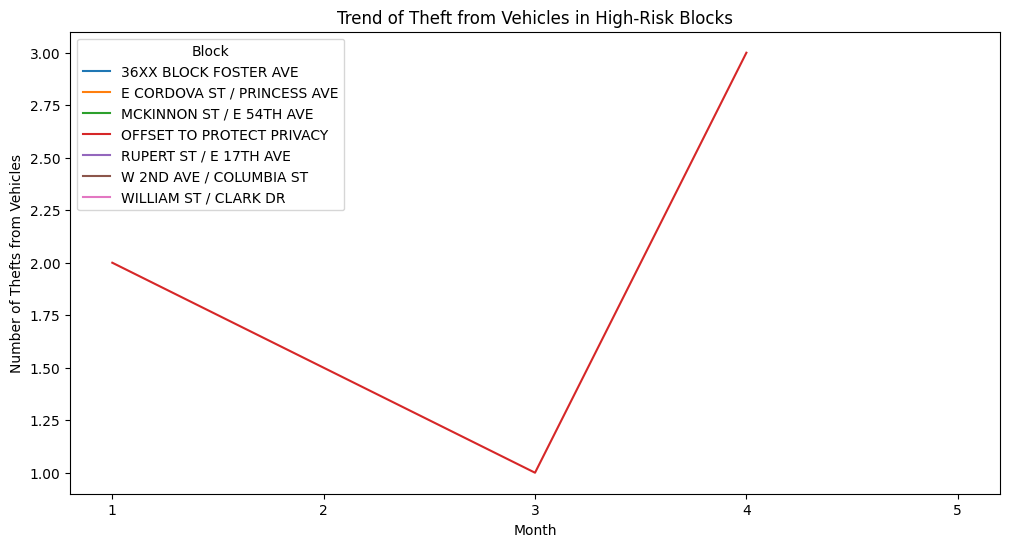

In [ ]:
# Plot the trend for each high-risk block for last 12 months
result_highrisk_pd = result_highrisk.toPandas() # Convert PySpark DataFrame to Pandas DataFrame

plt.figure(figsize=(12, 6))
sns.lineplot(data=result_highrisk_pd, x='MONTH', y='Count', hue='HUNDRED_BLOCK') # Use the Pandas DataFrame
plt.xlabel('Month')
plt.ylabel('Number of Thefts from Vehicles')
plt.title('Trend of Theft from Vehicles in High-Risk Blocks')
plt.legend(title='Block')
plt.xticks(range(1, 6)) # Set x-axis labels for each month
plt.show()

What are the high-risk hours and locations for fatal vehicle collisions?

In [ ]:
query7 = spark.sql("""
SELECT TYPE, HOUR, HUNDRED_BLOCK, COUNT(*) AS Count
FROM CrimeData
WHERE TYPE = 'Vehicle Collision or Pedestrian Struck (with Fatality)'
GROUP BY TYPE, HOUR, HUNDRED_BLOCK
ORDER BY Count DESC
""")

result7_df = query7.toPandas()

HOUR
15    22
12    21
17    21
14    20
22    18
19    17
10    17
18    15
9     14
1     13
Name: Count, dtype: int64

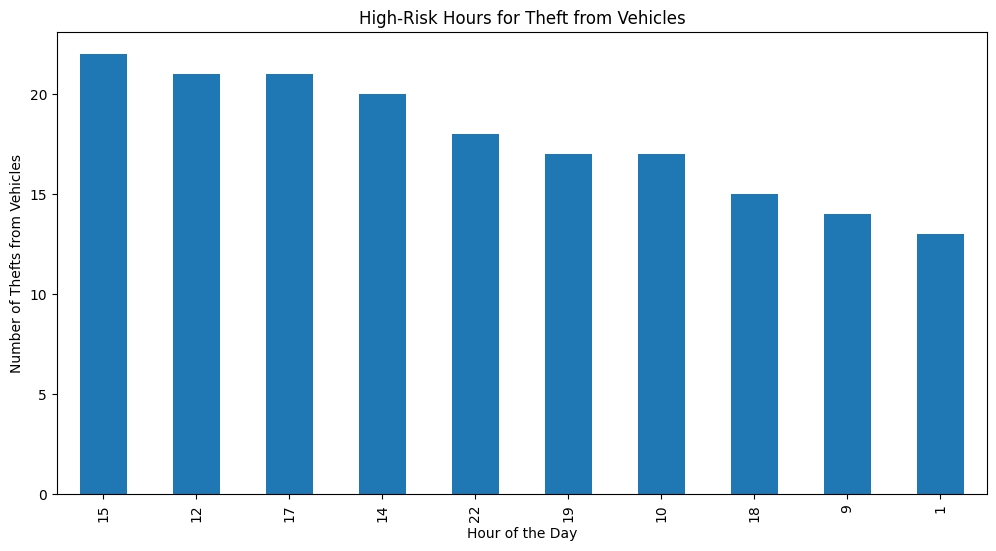

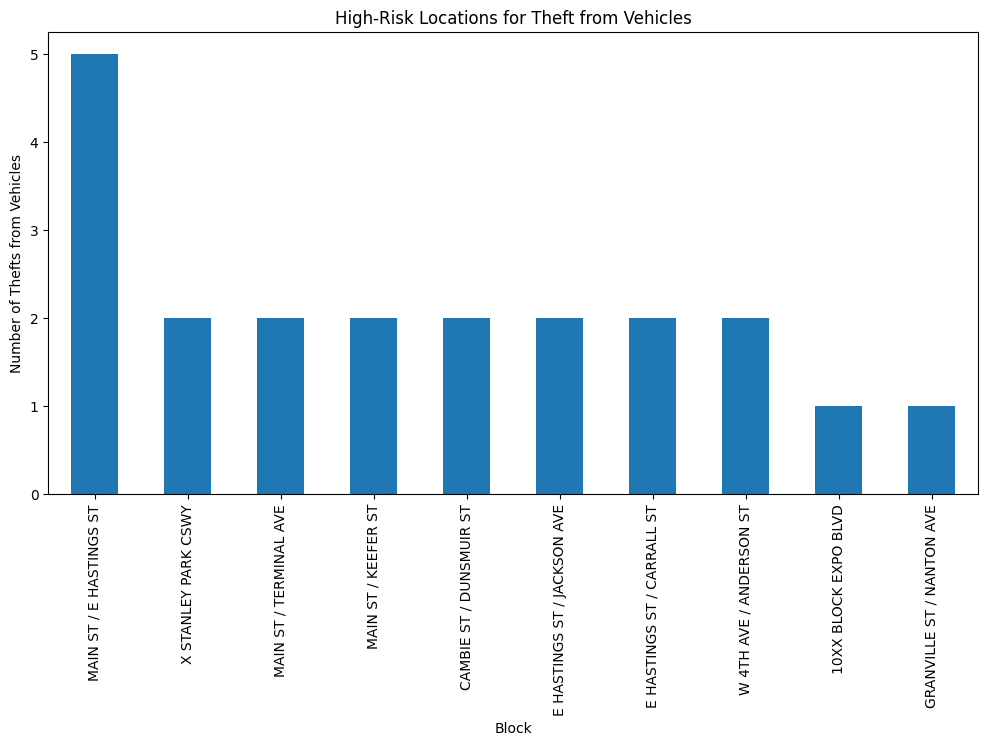

In [ ]:
# Plot high-risk hours (top 10)
top_hours = result7_df.groupby("HOUR")['Count'].sum().sort_values(ascending=False).head(10)
display(top_hours)

plt.figure(figsize=(12, 6))
top_hours.plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Thefts from Vehicles')
plt.title('High-Risk Hours for Theft from Vehicles')
plt.show()

# Plot high-risk locations (top 10)
top_locations = result7_df.groupby("HUNDRED_BLOCK")['Count'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_locations.plot(kind='bar')
plt.xlabel('Block')
plt.ylabel('Number of Thefts from Vehicles')
plt.title('High-Risk Locations for Theft from Vehicles')
plt.show()

How does the frequency of offenses causing death vary across different neighborhoods or areas?

In [ ]:
query11 ="""
SELECT NEIGHBOURHOOD, COUNT(TYPE) AS Count, X, Y
FROM CrimeData
GROUP BY NEIGHBOURHOOD, X, Y  -- Add this line to group the results
"""

result11_df = spark.sql(query11)
result11_df.show()

result11_pd_df = result11_df.toPandas()

+--------------------+-----+--------+---------+
|       NEIGHBOURHOOD|Count|       X|        Y|
+--------------------+-----+--------+---------+
|Central Business ...|    1|490774.0|5458511.0|
|              Sunset|    1|494376.0|5451033.0|
|     West Point Grey|    1|485473.0|5457347.0|
|    Hastings-Sunrise|    1|497925.0|5457402.0|
| Renfrew-Collingwood|   23|     0.0|      0.0|
|           Killarney|    1|497687.0|5450601.0|
|Central Business ...|    1|491334.0|5458937.0|
|            West End|    1|490264.0|5459755.0|
|    Hastings-Sunrise|    1|498024.0|5459735.0|
|            Fairview|    1|489423.0|5456930.0|
|           Kitsilano|    1|487562.0|5457605.0|
|            Oakridge|    1|491539.0|5453009.0|
|            Fairview|    1|490102.0|5457059.0|
|   Dunbar-Southlands|    1|     0.0|      0.0|
|      Mount Pleasant|    1|492749.0|5456683.0|
|      Mount Pleasant|    1|492657.0|5456975.0|
|          Strathcona|    2|493205.0|5458724.0|
|          Riley Park|    1|492622.0|545

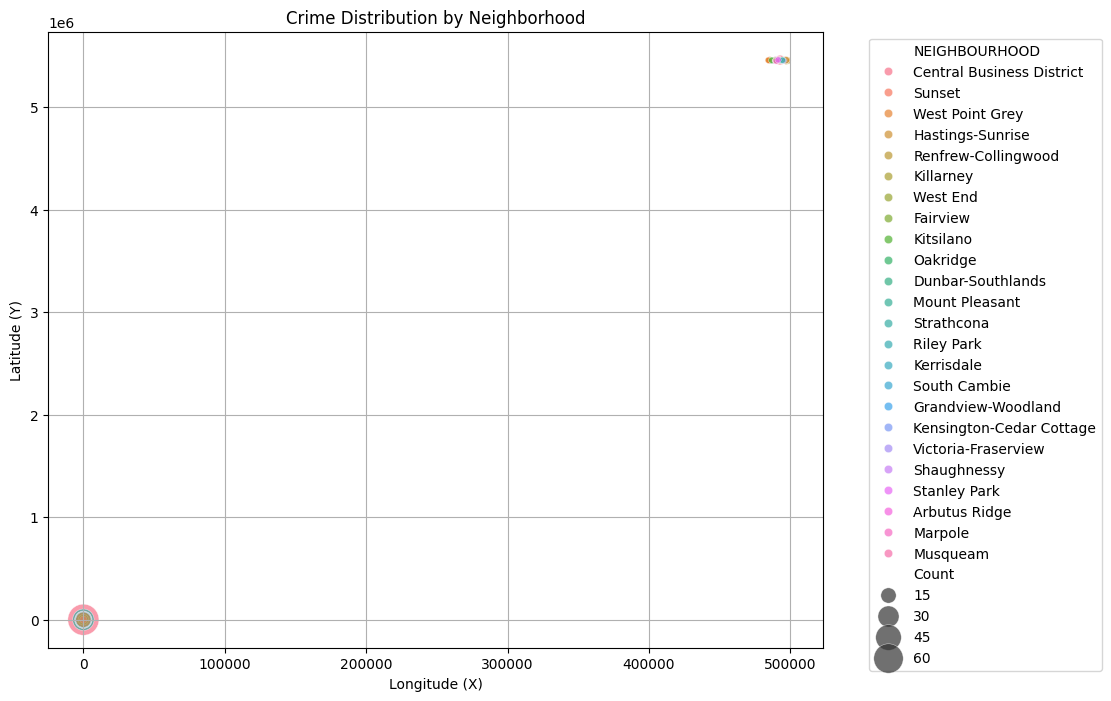

In [ ]:
# plt.figure(figsize=(10, 8))  # Adjust figure size as needed

# # Create the bubble chart
# plt.scatter(result5_pd_df['X'], result5_pd_df['Y'],
#             s=result5_pd_df['Count'] * 5,  # Adjust scaling factor for bubble size
#             alpha=0.7)  # Adjust transparency as needed

# plt.title('Crime Distribution by Neighborhood')
# plt.xlabel('Longitude (X)')
# plt.ylabel('Latitude (Y)')

# # Optionally, add labels for neighborhoods
# for i, row in result5_pd_df.iterrows():
#     plt.annotate(row['NEIGHBOURHOOD'], (row['X'], row['Y']))

# plt.grid(True)
# plt.show()

plt.figure(figsize=(10, 8))

# Create the bubble chart with hue for neighborhoods
sns.scatterplot(data=result11_pd_df,
                x='X',
                y='Y',
                size='Count',
                hue='NEIGHBOURHOOD',
                alpha=0.7,
                sizes=(20, 500))  # Adjust size range as needed

plt.title('Crime Distribution by Neighborhood')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')

plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.show()

How do offences related to death related to offences with the usage of weapon (Offences Against People vs (Homicide,Fatality)



In [ ]:
# Preprocess data
df_weapon_death = df.filter(
    (col("TYPE") == "Offences Against People") |
    (col("TYPE") == 'Homicide') |
    (col("TYPE") == 'Vehicle Collision or Pedestrian Struck (with Fatality)')
)

df_weapon_death.show()
# Find null values
missing_data_weapon = df_weapon_death.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data_weapon.show()

df_weapon_death = df_weapon_death.dropna()
df_weapon_death = df_weapon_death.dropDuplicates()

df_weapon_death.createOrReplaceTempView("HistoricalCrimeData")

+--------------------+----+-----+---+----+------+--------------------+--------------------+-----------+------------+
|                TYPE|YEAR|MONTH|DAY|HOUR|MINUTE|       HUNDRED_BLOCK|       NEIGHBOURHOOD|          X|           Y|
+--------------------+----+-----+---+----+------+--------------------+--------------------+-----------+------------+
|Vehicle Collision...|2005|   11| 30|   2|    41|10XX BLOCK EXPO BLVD|Central Business ...|   491543.0|   5458003.0|
|Vehicle Collision...|2005|   11| 11|   1|    10|  10XX W HASTINGS ST|Central Business ...|   491461.0|   5459401.0|
|Vehicle Collision...|2009|    2|  9|  15|    31| 11XX BLOCK DAVIE ST|            West End|   490431.0|   5458660.0|
|Vehicle Collision...|2006|   10| 22|  22|    26|11XX BLOCK E 60TH...|              Sunset|   493983.0|   5451421.0|
|Vehicle Collision...|2018|   12| 27|   5|     1|11XX BLOCK KINGSW...|Kensington-Cedar ...|   494071.0|   5455562.0|
|Vehicle Collision...|2015|    8| 19|  22|    27|11XX BLOCK SE M

In [ ]:
# SQL query to analyze temporal patterns by hour
hourly_agg_query = """
SELECT TYPE, HOUR, COUNT(*) AS Count
FROM HistoricalCrimeData
WHERE TYPE IN ('Offense Against a Person', 'Homicide', 'Vehicle Collision or Pedestrian Struck (with Fatality)')
GROUP BY TYPE, HOUR
ORDER BY TYPE, HOUR
"""

hourly_agg_df = spark.sql(hourly_agg_query)
hourly_agg_df.show()

# SQL query to analyze temporal patterns by month
monthly_agg_query = """
SELECT TYPE, MONTH, COUNT(*) AS Count
FROM HistoricalCrimeData
WHERE TYPE IN ('Offense Against a Person', 'Homicide', 'Vehicle Collision or Pedestrian Struck (with Fatality)')
GROUP BY TYPE, MONTH
ORDER BY TYPE, MONTH
"""

monthly_agg_df = spark.sql(monthly_agg_query)
monthly_agg_df.show()


+--------------------+----+-----+
|                TYPE|HOUR|Count|
+--------------------+----+-----+
|            Homicide|   0|  279|
|Vehicle Collision...|   0|    9|
|Vehicle Collision...|   1|   13|
|Vehicle Collision...|   2|    8|
|Vehicle Collision...|   3|   11|
|Vehicle Collision...|   4|   11|
|Vehicle Collision...|   5|   11|
|Vehicle Collision...|   6|    3|
|Vehicle Collision...|   7|    7|
|Vehicle Collision...|   8|    6|
|Vehicle Collision...|   9|   14|
|Vehicle Collision...|  10|   17|
|Vehicle Collision...|  11|   12|
|Vehicle Collision...|  12|   21|
|Vehicle Collision...|  13|   12|
|Vehicle Collision...|  14|   20|
|Vehicle Collision...|  15|   22|
|Vehicle Collision...|  16|    9|
|Vehicle Collision...|  17|   21|
|Vehicle Collision...|  18|   15|
+--------------------+----+-----+
only showing top 20 rows

+--------------------+-----+-----+
|                TYPE|MONTH|Count|
+--------------------+-----+-----+
|            Homicide|    1|   29|
|            Homic

In [ ]:
# SQL query to analyze spatial patterns by block
block_agg_query = """
SELECT TYPE, HUNDRED_BLOCK, COUNT(*) AS Count
FROM HistoricalCrimeData
WHERE TYPE IN ('Offense Against a Person', 'Homicide', 'Vehicle Collision or Pedestrian Struck (with Fatality)')
GROUP BY TYPE, HUNDRED_BLOCK
ORDER BY TYPE, Count DESC
"""

block_agg_df = spark.sql(block_agg_query)
block_agg_df.show()


+--------------------+--------------------+-----+
|                TYPE|       HUNDRED_BLOCK|Count|
+--------------------+--------------------+-----+
|            Homicide|OFFSET TO PROTECT...|  279|
|Vehicle Collision...|MAIN ST / E HASTI...|    5|
|Vehicle Collision...|E HASTINGS ST / J...|    2|
|Vehicle Collision...|CAMBIE ST / DUNSM...|    2|
|Vehicle Collision...| MAIN ST / KEEFER ST|    2|
|Vehicle Collision...|MAIN ST / TERMINA...|    2|
|Vehicle Collision...|W 4TH AVE / ANDER...|    2|
|Vehicle Collision...| X STANLEY PARK CSWY|    2|
|Vehicle Collision...|E HASTINGS ST / C...|    2|
|Vehicle Collision...|GRANVILLE ST / NA...|    1|
|Vehicle Collision...|ETON ST / N RENFR...|    1|
|Vehicle Collision...|VICTORIA DR / SE ...|    1|
|Vehicle Collision...|42XX BLOCK W 16TH...|    1|
|Vehicle Collision...|CAMBIE ST / W 54T...|    1|
|Vehicle Collision...|MAIN ST / E BROAD...|    1|
|Vehicle Collision...|   8XX BLOCK HOWE ST|    1|
|Vehicle Collision...|   5XX CENTENNIAL RD|    1|


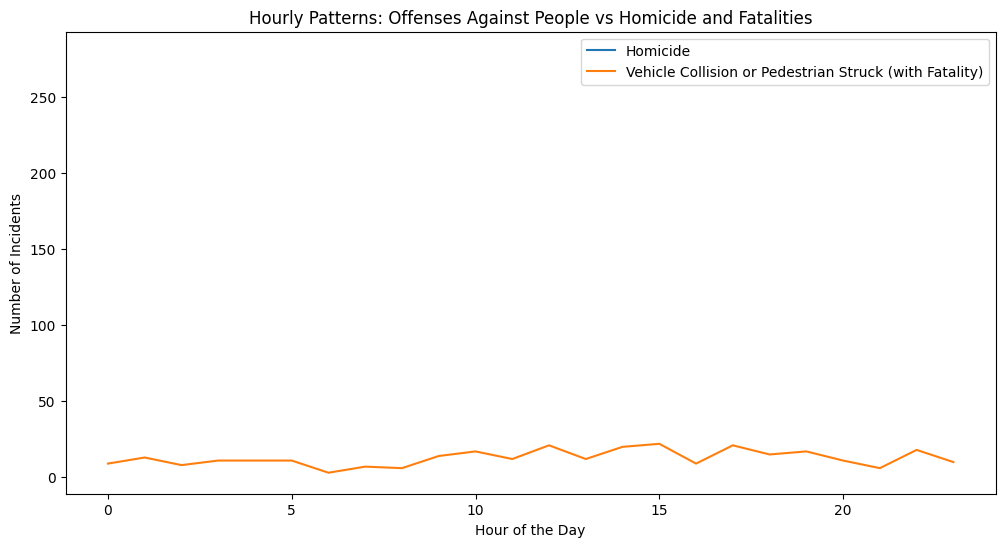

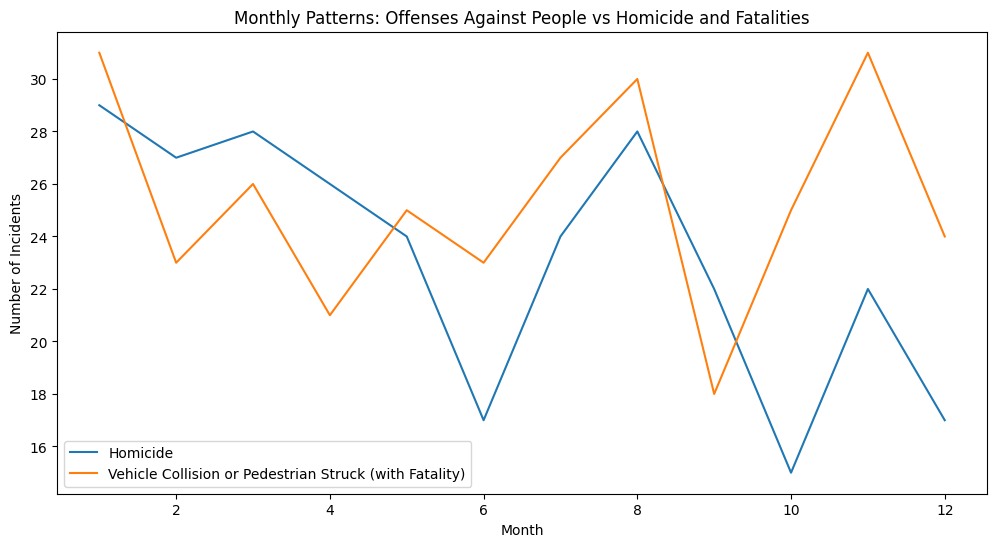

<Figure size 1200x600 with 0 Axes>

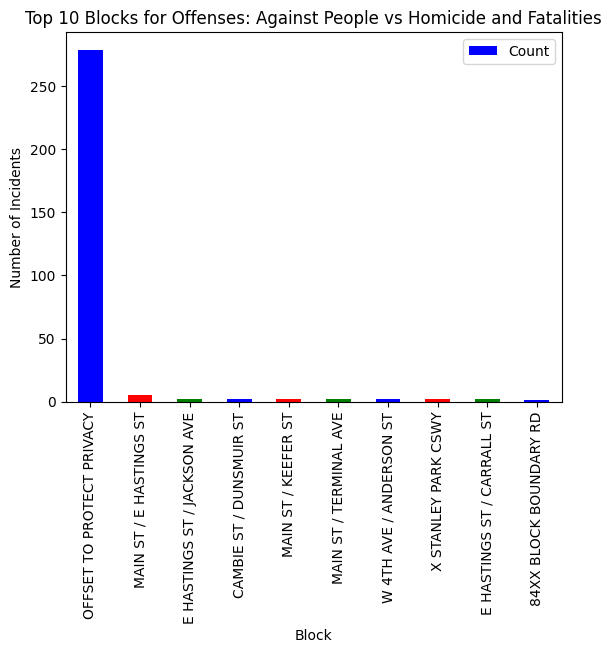

In [ ]:
hourly_agg_pd = hourly_agg_df.toPandas()
monthly_agg_pd = monthly_agg_df.toPandas()
block_agg_pd = block_agg_df.toPandas()

# Plot temporal patterns by hour
plt.figure(figsize=(12, 6))
# Iterate through unique crime types in the 'TYPE' column
for crime_type in hourly_agg_pd['TYPE'].unique():
    subset = hourly_agg_pd[hourly_agg_pd['TYPE'] == crime_type]
    plt.plot(subset['HOUR'], subset['Count'], label=crime_type)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.title('Hourly Patterns: Offenses Against People vs Homicide and Fatalities')
plt.legend()
plt.show()

# Plot temporal patterns by month
plt.figure(figsize=(12, 6))
# Iterate through unique crime types in the 'TYPE' column
for crime_type in monthly_agg_pd['TYPE'].unique():
    subset = monthly_agg_pd[monthly_agg_pd['TYPE'] == crime_type]
    plt.plot(subset['MONTH'], subset['Count'], label=crime_type)
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.title('Monthly Patterns: Offenses Against People vs Homicide and Fatalities')
plt.legend()
plt.show()

# Plot spatial patterns by block (top 10 blocks)
# Rename the 'HUNDRED_BLOCK' column to 'BLOCK' for plotting
block_agg_pd = block_agg_pd.rename(columns={'HUNDRED_BLOCK': 'BLOCK'})
top_blocks = block_agg_pd.sort_values(by='Count', ascending=False).head(10)
plt.figure(figsize=(12, 6))
# Use the renamed 'BLOCK' column for the x-axis
top_blocks.plot(kind='bar', x='BLOCK', y='Count', color=['blue', 'red', 'green'])
plt.xlabel('Block')
plt.ylabel('Number of Incidents')
plt.title('Top 10 Blocks for Offenses: Against People vs Homicide and Fatalities')
plt.show()

How can predictive modeling help in identifying emerging hotspots for offenses causing death?